<a href="https://colab.research.google.com/github/yashi4/length-of-stay-prediction/blob/main/Length_of_stay_prediction_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Commands to access the datasets on Kaggle
#Make a seperate directory for kaggle and give access for Kaggle to export datasets
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
#Download the dataset
!kaggle datasets download -d omkarmanohardalvi/lungs-disease-dataset-4-types

Dataset URL: https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types
License(s): unknown
100% 2.02G/2.02G [01:37<00:00, 22.2MB/s]
100% 2.02G/2.02G [01:37<00:00, 22.2MB/s]


In [ ]:
# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import random


In [ ]:
#Unzipping the zipfile of images
import zipfile

data_zip = zipfile.ZipFile('/content/lungs-disease-dataset-4-types.zip')
data_zip.extractall()
data_zip.close()

There are two folders in the datasets- One with original images and the other with augmented images.

Seperate them by assigning them as testing and training, respectively.

In [ ]:
#Create seperate directories for training and testing images.

train_dir = '/content/Lung Disease Dataset/train'
test_dir = '/content/Lung Disease Dataset/test'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The images are further partitioned into training and validation images with 80% training and 20% validation.

DATA PREPROCESSING

In [ ]:


train_datagen = ImageDataGenerator(rescale = 1/255. , validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir ,
                                               target_size = (224 , 224),    #Set image size.
                                               batch_size = 32,              #Set appropriate batch size to avoid overfitting.
                                               class_mode = 'categorical',   #Set type of labels.
                                               subset = 'training')

valid_data = train_datagen.flow_from_directory(train_dir,
                                               target_size = (224 , 224),
                                               batch_size = 32,
                                               class_mode = 'categorical',
                                               subset = 'validation')

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size = (224 , 224),         #Images from the OriginalDataset directory to be used for testing only
                                             batch_size = 32,
                                             class_mode = 'categorical')

Found 4845 images belonging to 5 classes.
Found 1209 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


In [ ]:
#Define a function to plot the loss and accuracy curves of model training for better visualization.

def loss_and_accuracy(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs , loss , label = 'Training Loss')
  plt.plot(epochs , val_loss , label = 'Validation Loss')            #Loss curve
  plt.title('Loss Curve')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig('Loss_Curve.jpg')

  plt.figure()

  plt.plot(epochs , accuracy , label = 'training_accuracy')
  plt.plot(epochs , val_accuracy , label = 'validation_accuracy')    #Accuracy curve
  plt.title('Accuracy Curve')
  plt.yticks([0,0.2,0.4,0.6,0.8,1])
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig('Accuracy_Curve.jpg')

In [ ]:
#Give the classnames as a list
classnames = ['Bacterial Pneumonia' , 'Corona Virus Disease' ,'Normal', 'Tuberculosis','Viral Pneumonia']

In [ ]:
#Define a function to prepare an image for prediction

def image_prep(filename , img_size = 224):
  #Read the image from filename
  image = tf.io.read_file(filename)
  #Decode the image into its RGB channels
  image = tf.image.decode_image(image , channels = 3)
  #Resize the image
  image = tf.image.resize(image , size = [img_size , img_size])
  #Rescale
  image = image/255.

  return image

In [ ]:
def get_length_of_stay(pred_class):
    # Define the cases as a dictionary
    cases = {
        'Bacterial Pneumonia': lambda: random.randrange(4, 8, 1),
        'Corona Virus Disease': lambda: random.randrange(10, 20, 1),
        'Normal': lambda: 0,
        'Tuberculosis': lambda: random.randrange(62, 77, 1),
        'Viral Pneumonia': lambda: random.randrange(30, 61, 1),
    }
    return los

In [ ]:
#Define a function to make predictions on the prepared images
#Image along with the classified label is shown as output

def make_predictions(model , filename , classnames):
  #Load the image
  image = image_prep(filename)
  #Run the model on the image
  pred = model.predict(tf.expand_dims(image , axis=0))
  #Zero down on the class
  pred_class = classnames[tf.argmax(tf.round(pred)[0])]
  #Show the image and the label
  los=get_length_of_stay(pred_class)
  print(los)
  plt.imshow(image)
  plt.title(f'Predicted class: {pred_class}')
  plt.axis(False)



In [ ]:
# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)  # Flatten the output of VGG16
x = Dense(256, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(5, activation='softmax')(x)  # 4 classes for output

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Adjust learning rate if needed
              loss='categorical_crossentropy',  # Loss for multi-class classification
              metrics=['accuracy'])


In [ ]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_1 = model.fit(train_data,
                    epochs=25,
                    steps_per_epoch = 100,
                    validation_data = valid_data,
                    callbacks = [early_stopping],
                    verbose = 0)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
len(history_1.history['loss'])

19

In [ ]:
model.evaluate(train_data)

152/152 ━━━━━━━━━━━━━━━━━━━━ 50s 327ms/step - accuracy: 0.9300 - loss: 0.2027


[0.19769525527954102, 0.9306501746177673]

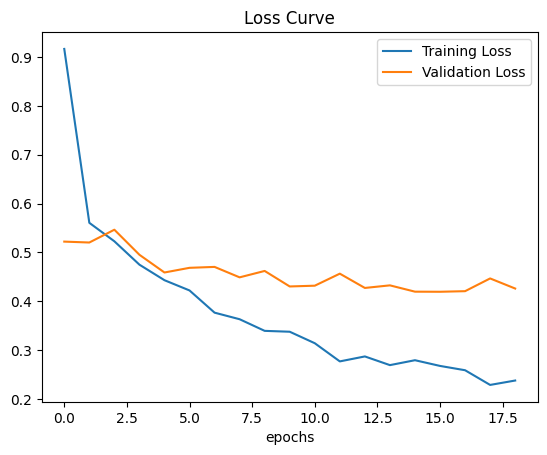

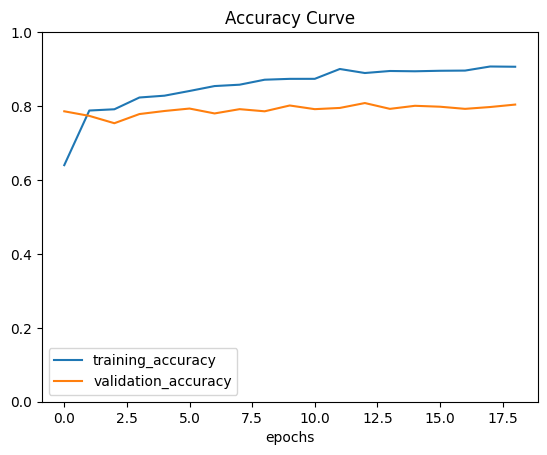

In [ ]:
loss_and_accuracy(history = history_1)

In [ ]:
make_predictions(model , '/content/Lung Disease Dataset/test/Tuberculosis/Tuberculosis-101.jpg' , classnames )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


NameError: name 'los' is not defined